In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
import matplotlib.pyplot as plt

In [3]:
device = 'cuda:2'
conf = chexpert256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = chexpert256_autoenc_cls_1000k()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 90M
step: 7674693
loading latent stats ...
latent step: 62500


In [22]:
# data = conf.make_dataset()
# batch = data[10]['img'][None]

In [5]:
data = ImageDataset('../Stanford_MIT_CHEST/MIMIC-CXR-v2.0/mimic-cxr/', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[10]['img'][None]

In [6]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


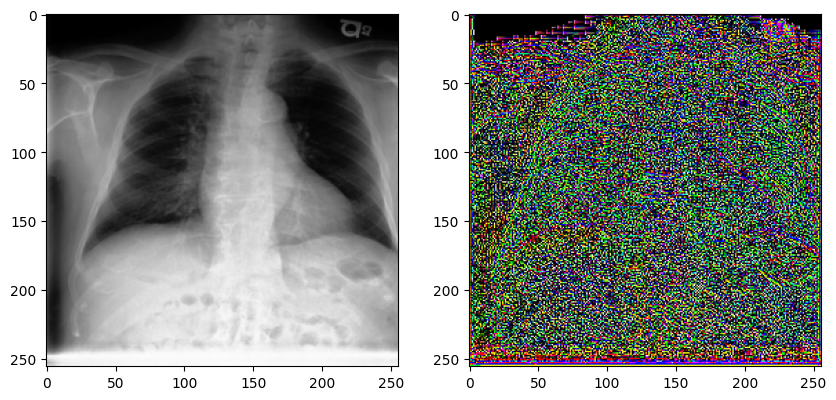

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [8]:
dataset = ChexpertAttrDataset(image_size=256)
len(dataset)
dataset.PRED_LABEL

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

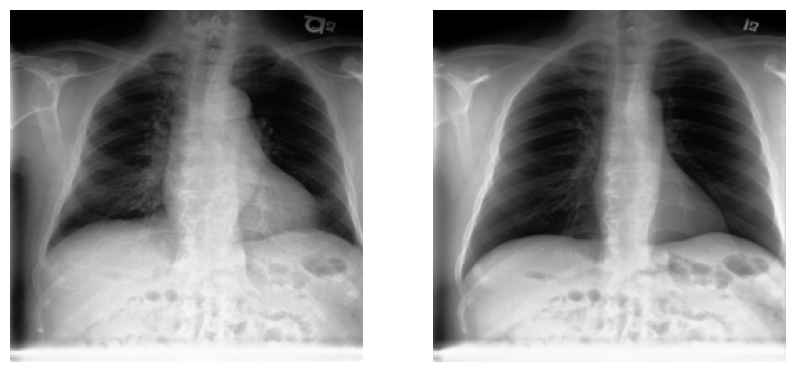

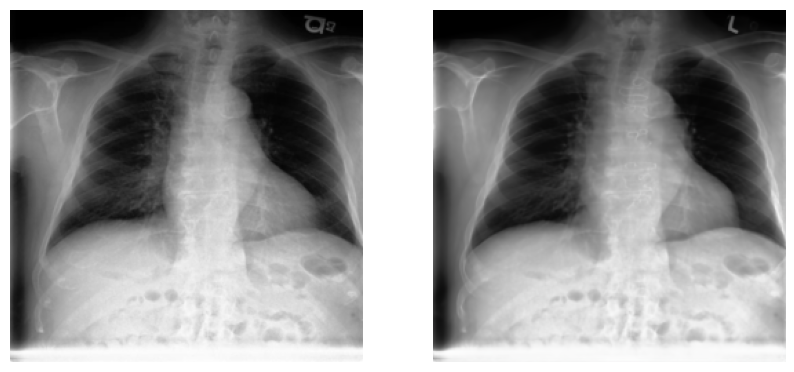

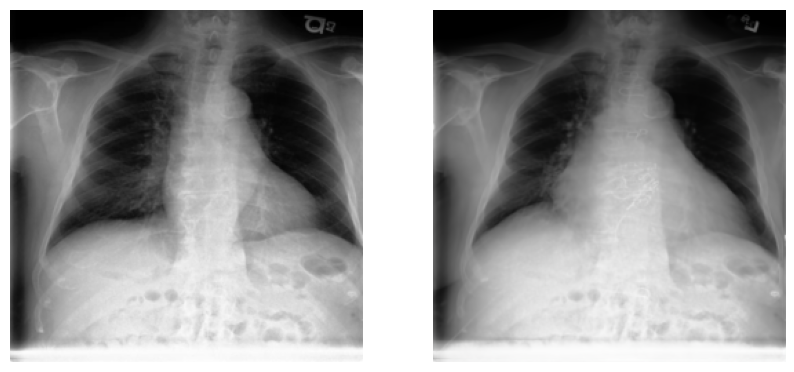

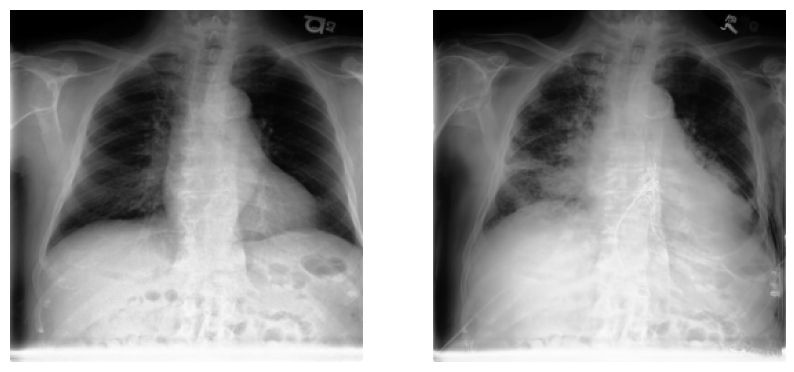

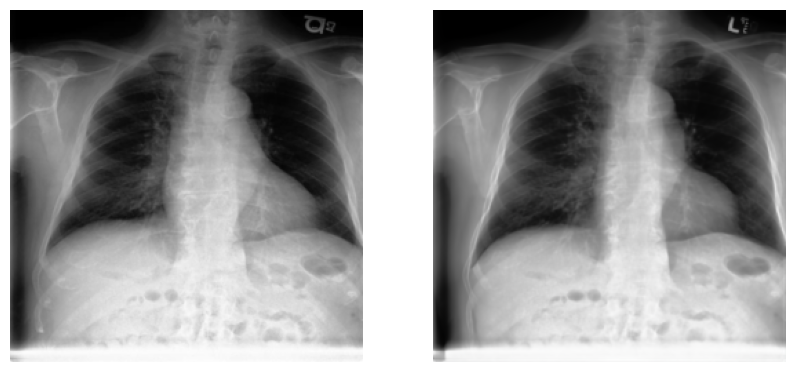

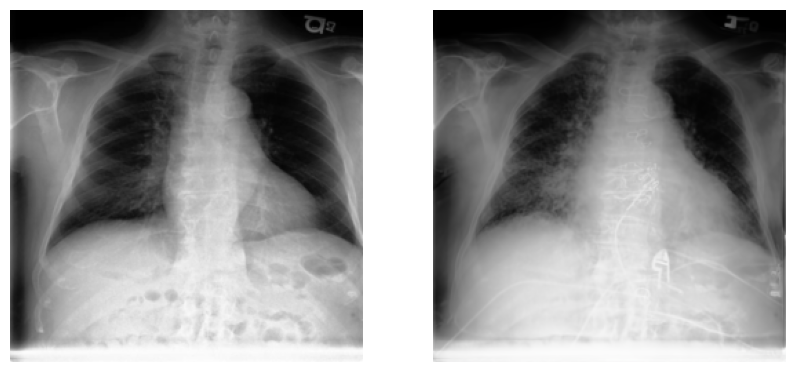

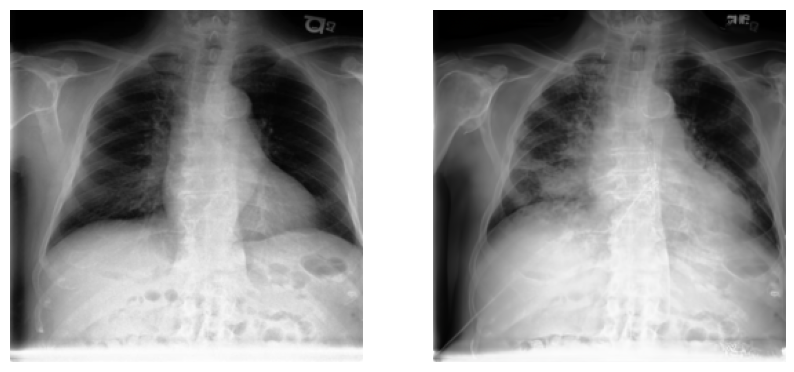

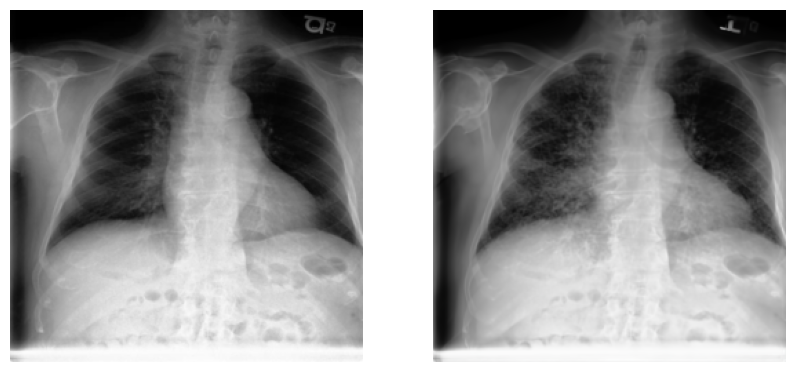

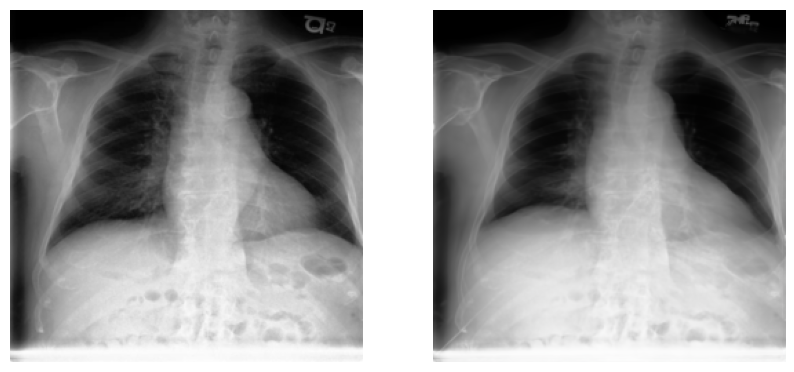

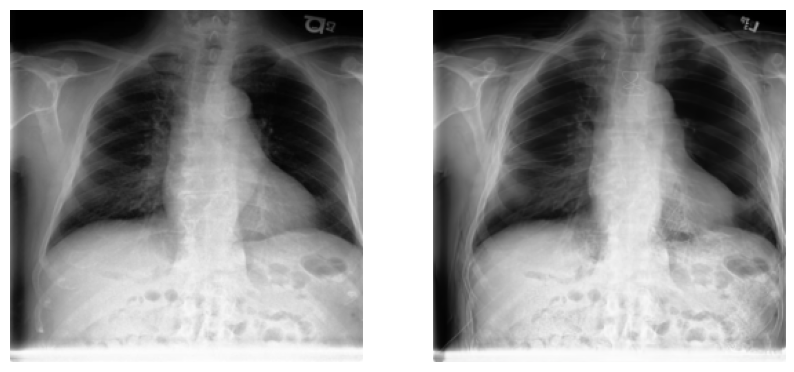

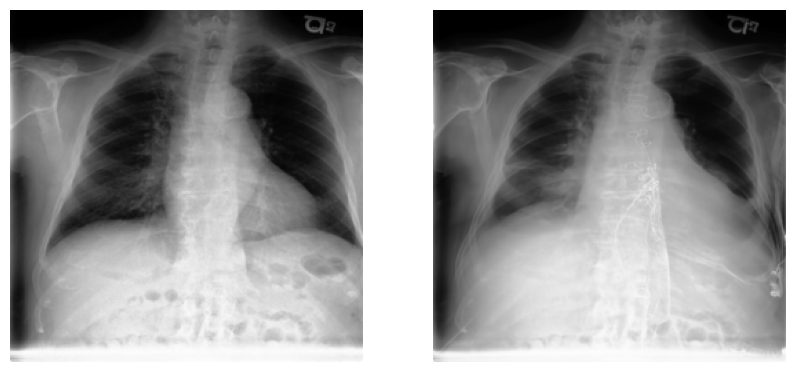

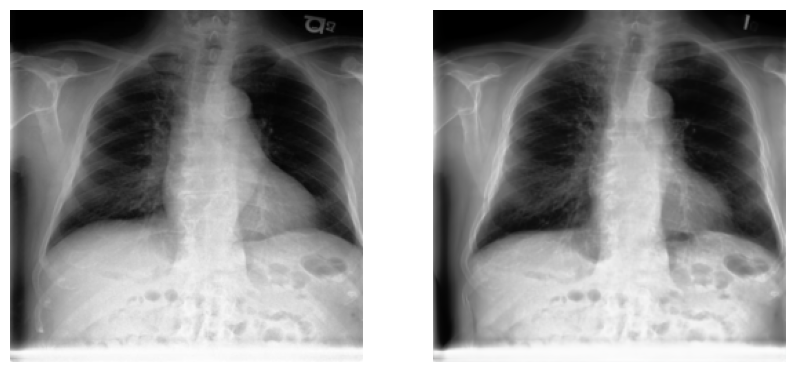

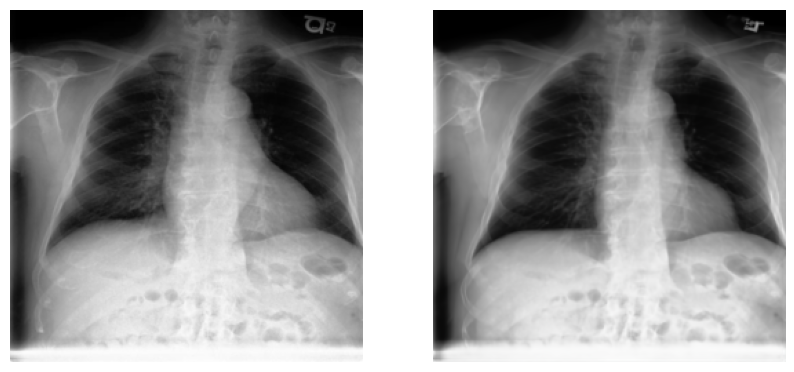

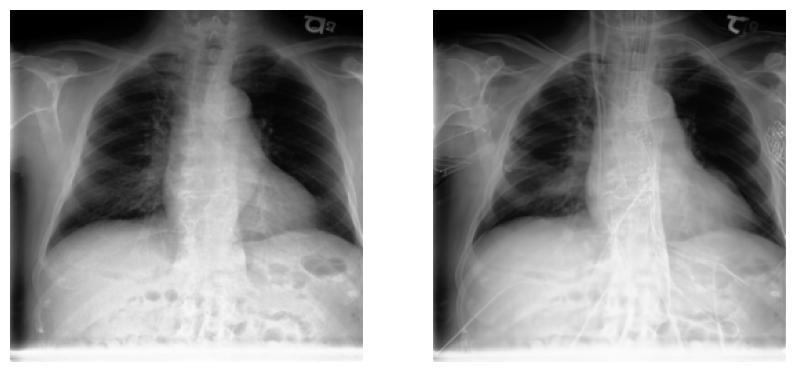

In [10]:
for cls_id, label in enumerate(dataset.PRED_LABEL):
    cond2 = cls_model.normalize(cond)
    cond2 = cond2 + 0.6 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
    cond2 = cls_model.denormalize(cond2)
    # torch.manual_seed(1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    img = model.render(xT, cond2, T=1000)
    ori = (batch + 1) / 2
    ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
    ax[1].imshow(img[0].permute(1, 2, 0).cpu())
    ax[0].axis('off')
    ax[1].axis('off')
    _ = fig.savefig('./imgs_manipulated/'+label+'.png', bbox_inches='tight', dpi=500)

In [34]:
from torchvision.utils import *
save_image(img[0], 'imgs_manipulated/output.png')